# Neural Network: Final model

This notebook features the best model found using neural networks. It uses 3000 features (trigrams, tf-idf) as input, a single hidden layer using ReLu with 3000 neurons and a sigmoid activation function at the output layer.

In [1]:
%run notebook_utils.py

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [3]:
%cd ..
from langid import WrappedVectorizer, np_sanitize, sanitize
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import SGD
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


## load data

In [5]:
X_train, X_test, y_train, y_test = load_split_data()
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

# Model training

In [6]:
ngram_range = (3,3)
num_features = 3000

# create the vectorizer
vectorizer = WrappedVectorizer(
    analyzer='char', 
    ngram_range=ngram_range, 
    sg_only=False,
    max_features=num_features, 
    sublinear_tf=True, 
    use_idf=True, 
    norm='l2'
)

# create the features for training
X = vectorizer.fit_transform(X_train, y_train)

In [18]:
# create model
hidden_size = 3000
output_size = len(langs)

model = Sequential()
model.add(Dense(hidden_size, input_dim=num_features, activation='relu'))
model.add(Dense(output_size, activation='sigmoid')) 
model.add(Activation("softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3000)              9003000   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 15005     
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total params: 9,018,005
Trainable params: 9,018,005
Non-trainable params: 0
_________________________________________________________________


In [8]:
# train the model using SGD
print("[INFO] compiling model...")
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model.fit(X, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 14s 470us/step - loss: 1.6090 - acc: 0.2202
Epoch 2/50
29551/29551 [==============================] - 15s 494us/step - loss: 1.6077 - acc: 0.3081
Epoch 3/50
29551/29551 [==============================] - 15s 512us/step - loss: 1.6063 - acc: 0.4255
Epoch 4/50
29551/29551 [==============================] - 15s 513us/step - loss: 1.6049 - acc: 0.5635
Epoch 5/50
29551/29551 [==============================] - 15s 508us/step - loss: 1.6034 - acc: 0.6666
Epoch 6/50
29551/29551 [==============================] - 16s 558us/step - loss: 1.6020 - acc: 0.7561
Epoch 7/50
29551/29551 [==============================] - 18s 593us/step - loss: 1.6004 - acc: 0.8091
Epoch 8/50
29551/29551 [==============================] - 18s 623us/step - loss: 1.5989 - acc: 0.8613
Epoch 9/50
29551/29551 [==============================] - 19s 638us/step - loss: 1.5973 - acc: 0.8857
Epoch 10/50
29551/29551 [==============================]

# Model evaluation

[INFO] evaluating on testing set...
7388/7388 [==============================] - 1s 130us/step
[INFO] loss=1.4035, accuracy: 98.0103%
TEST SET
accuracy: 0.9801

             precision    recall  f1-score   support

         de     0.9466    0.9822    0.9641      1462
         fr     0.9973    0.9939    0.9956      1468
         en     0.9948    0.9883    0.9915      1538
         it     0.9920    0.9987    0.9953      1482
         sg     0.9697    0.9360    0.9526      1438

avg / total     0.9803    0.9801    0.9801      7388



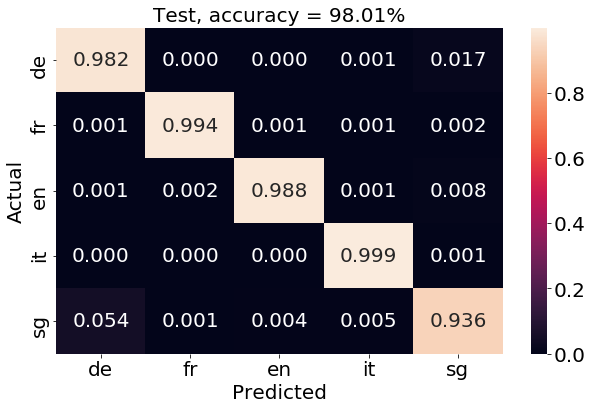

SMS RECALL
total samples    10692
total errors       389 (3.64%)
---------------------------------
languages detected
    de      367
    fr        9
    en        7
    it        6
    sg    10303


SMS ANY
accuracy: 0.8846

             precision    recall  f1-score   support

         de     0.9759    0.8060    0.8828       201
         fr     0.9841    0.9254    0.9538       201
         en     1.0000    0.7413    0.8514       201
         it     0.9898    0.9701    0.9799       201
         sg     0.6480    0.9801    0.7802       201

avg / total     0.9196    0.8846    0.8896      1005



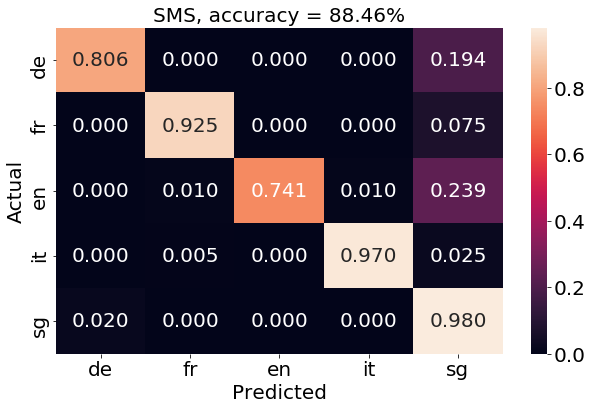



VALIDATION SET
accuracy: 0.9720

             precision    recall  f1-score   support

         de     0.9034    0.9805    0.9404      2613
         fr     0.9988    0.9950    0.9969      2613
         en     0.9965    0.9943    0.9954      2613
         it     0.9973    0.9981    0.9977      2613
         sg     0.9696    0.8921    0.9292      2613

avg / total     0.9731    0.9720    0.9719     13065



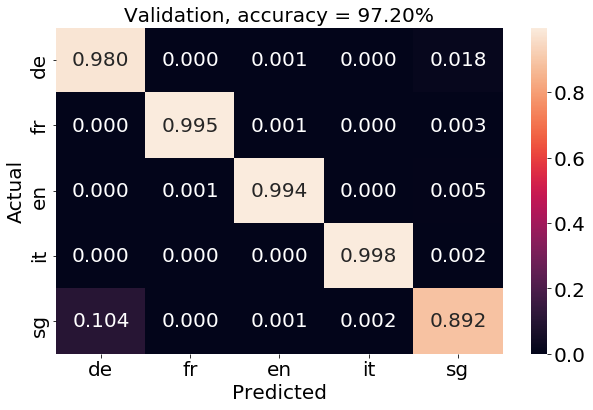

In [13]:
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(vectorizer.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("TEST SET")
print("========")
y_pred = model.predict(vectorizer.transform(X_test)).argmax(axis=1)
print_results(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, normalised=True, 
    title="Test, accuracy = %.2f%%" % (metrics.accuracy_score(y_test, y_pred) * 100))

print("SMS RECALL")
print("==========")
sms_predicted = model.predict(vectorizer.transform(sms_sg)).argmax(axis=1)
error_idx = np.argwhere(sms_predicted != 4).flatten()   
stats = metrics.confusion_matrix([4] * len(sms_predicted), sms_predicted)[-1]
print("total samples %8d" % len(sms_predicted))
print("total errors  %8d (%.2f%%)" % (len(error_idx), len(error_idx) / len(sms_predicted) * 100))
print("---------------------------------")
print("languages detected")
for t in zip(langs, stats):
    print("    %s %8d" % t)

    
print("\n\nSMS ANY")
print("==========")
y_sms_any_pred = model.predict(vectorizer.transform(sms_any_X)).argmax(axis=1)
print_results(sms_any_y, y_sms_any_pred)
plot_confusion_matrix(sms_any_y, y_sms_any_pred, normalised=True,
    title="SMS, accuracy = %.2f%%" % (metrics.accuracy_score(sms_any_y, y_sms_any_pred) * 100))

print("\n\nVALIDATION SET")
print("===============")
y_valid_pred = model.predict(vectorizer.transform(X_valid)).argmax(axis=1)
print_results(y_valid, y_valid_pred)
plot_confusion_matrix(y_valid, y_valid_pred, normalised=True,
    title="Validation, accuracy = %.2f%%" % (metrics.accuracy_score(y_valid, y_valid_pred) * 100))

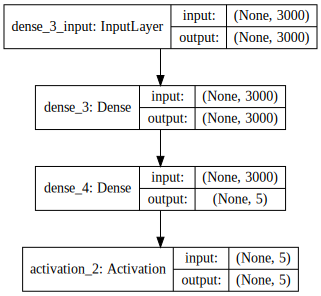

In [16]:
# Note: you need graphviz installed on your machine for this to work,
# as well as pydot and graphviz installed on your anaconda environment
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))